In [1]:
# installed dependencies
# -------------------------------------------------------
import os
import sys
# import glob
import pygmt
import numpy as np
import pandas as pd 
# import matplotlib
import matplotlib.pyplot as plt
# from obspy import read_inventory
# make paths above 'notebooks/' visible for local imports.
# ----------------------------------------
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# local dependencies
# -------------------------------------------------------
from plotconf import matsettings

# other stuff
# -------------------------------------------------------
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Yellowstone Maps
<p>This notebook is for creating relevent maps from our processed data.</p>

In [2]:
def tmp_files_for_mtfms(mw_cat: pd.DataFrame) -> None:
    """
    This function uses the dataframe to write temporary files 
    to disk that can be read by GMT 6's 'meca' code to plot moment
    tensor focal mechanisms (MTFMs), using the'aki' style convention.          
    
    It writes two files ".UUMw.tmp" and ".SLUMw.tmp". They are
    separate because we wanted to plot UUSS and SLU Mws 
    using separate calls for easy plot customisation.
    PyGMT version 0.3.1 docs state that to label the MTFMS, 
    you have to do it this way.
    
    See the docs (https://tinyurl.com/yvjm99mx).
    
    Parameters
    ----------
    mw_cat: pd.DataFrame
        The pandas dataframe that contains all of the event 
        location and MTFM data that is required for plotting.
    
    Notes
    -----
    The tiny url is NOT dangerous, it links to the PyGMT 
    'meca' function. 
    """
    labs = ["Lon", "Lat", "MTDep", "Strike",
            "Dip", "Rake", "MwPref", "LonS",
            "LatS","ID"
           ]
    tmp = mw_cat.copy()
    
    tmp["LonS"] = tmp["Lon"].values + np.array(
        [0.25, -0.15, 0.35, 0.35, -0.3, 0.15, -0.2, 0, -0.15, 0.15, -0.2, 0.25])
    tmp["LatS"] = tmp["Lat"].values + np.array(
        [0.01, -0.15, -0.15, 0.15, -0.1, -0.25, 0, 0.25, 0.15, 0.25, 0.35, -0.175])
    
    uu = tmp[tmp["UUSSMw"].notna()][labs]
    save_file(".UUMw.tmp", uu.to_numpy())
    
    slu = tmp[tmp["UUSSMw"].isna()][labs]
    save_file(".SLUMw.tmp", slu.to_numpy())
    
def save_file(name: str, arr: np.ndarray) -> None:
    """
    Saves a numpy array file to disk assuming that
    it is passed from tmp_files_for_mtfms. This 
    is because the string (number) formatting 
    that is epected is specific to that expected 
    output.
    
    Parameters
    ----------
    name: str
        The name of the text file to be saved to disk.
    arr: np.ndarray
        The numpy array (matrix) with shape N * 10.
    
    Notes
    -----
    Expected data types are:
        - Event longitude (deg) e.g. 100.0000
        - Event latitude (deg) e.g. 45.0000
        - Event depth (km) e.g. 15.00
        - MTFM strike (deg) e.g. 180
        - MTFM dip (deg) e.g. 45
        - MTFM rake (deg) e.g. -100
        - MTFM moment magnitude e.g. 3.00
        - Plotting longitude (deg) e.g. 101.0000
        - Plottong latitude (deg) e.g. 46.0000
        - MTFM label (str) e.g. 01
            
    """
    
    assert type(name) is str
    assert type(arr) is np.ndarray
    np.savetxt(
        name, 
        arr, 
        fmt = [
            "%6.4f",
            "%6.4f",
            "%4.2f",
            "%03d", 
            "%2d", 
            "%4d", 
            "%3.2f",
            "%6.4f",
            "%6.4f",
            "%02d",
        ]
    )
    

### Map 1. - Yellowstone National Park overview and MT focal mechs.

In [3]:
# load global variables and databases
# -----------------------------------

mw_cat = pd.read_csv("../catalogs/events/MTCAT.csv")
ev_cat = pd.read_csv(
    "../catalogs/events/yellowstone.catalog.all.csv", 
)

ys_bound = np.loadtxt("../utmaplines/Lines/prkbord.ys")
ys_bound = ys_bound[~np.all(ys_bound == 0, axis=1)]

# load 
tmp_files_for_mtfms(mw_cat.copy())

/var/folders/rp/8sbsdrv12vxcv2m5tfwp4rf00000gn/T/ipykernel_73758/2060351879.py:16: SyntaxWarning: Short-form parameter (L) is not recommended. Use long-form parameter 'map_scale' instead.
  fig.basemap(


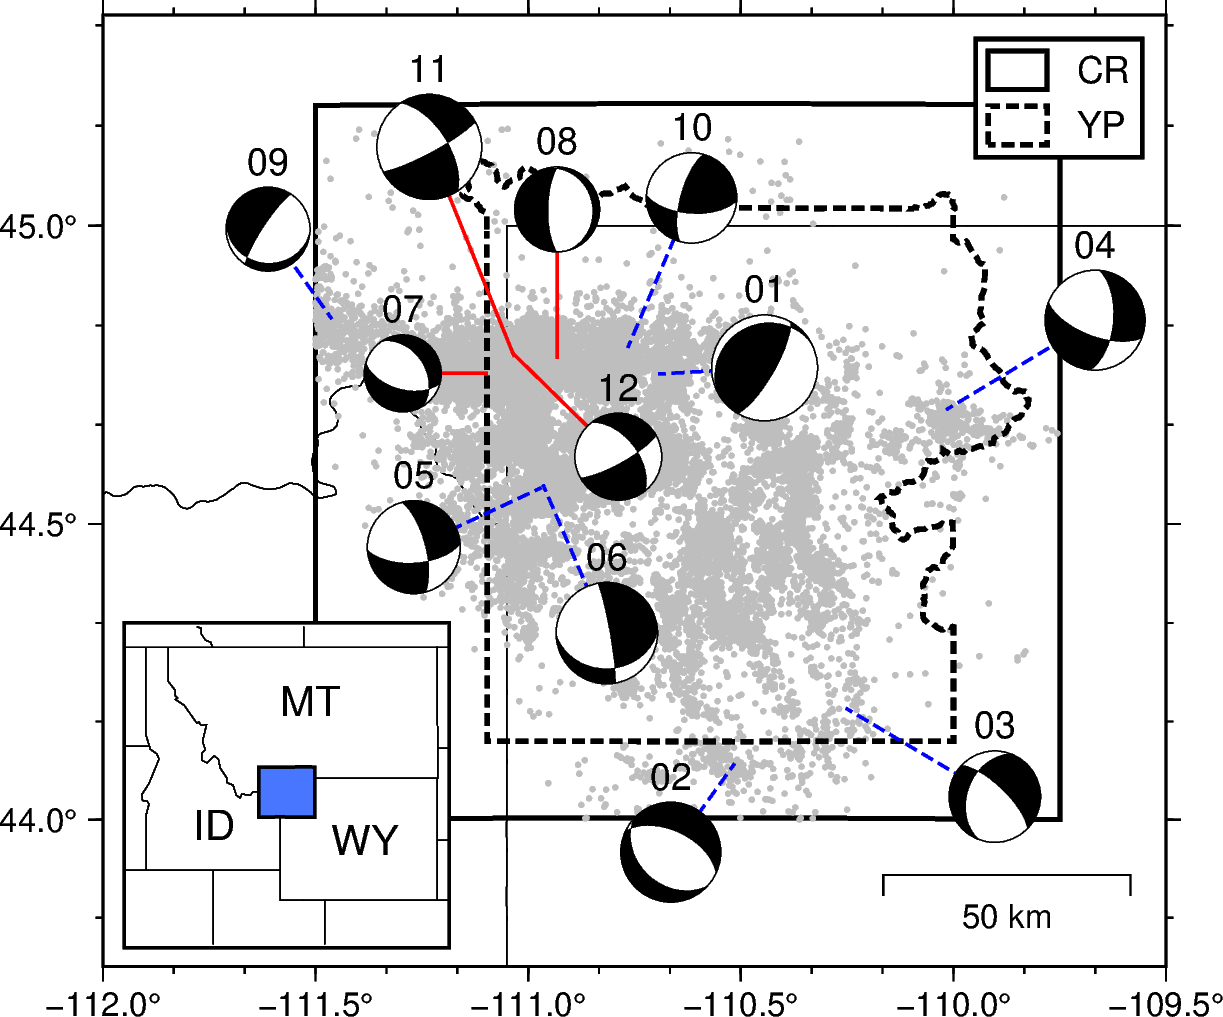

In [4]:
STUDYREG = np.array([-111.5, -109.75, 44.00, 45.2])
YPCATREG = np.array([-112, -109.5, 43.75, 45.35])
YPLAT, YPLON = ys_bound.copy().T
YPLON *= -1
lab_font = "10p,Helvetica,black"
fac = 0.9

fig = pygmt.Figure()
with pygmt.config(
    MAP_FRAME_TYPE="plain", 
    FORMAT_GEO_MAP="ddd.x", 
    MAP_FRAME_PEN="0.6p,black",
    FONT_ANNOT_PRIMARY="8p,Helvetica,black"
    ):
    # base of the figure
    fig.basemap(
        region = YPCATREG, 
        projection = f"M{6*fac}/{10*fac}", 
        frame = ["WSne", "xaf+lx-axis", "yaf+ly-axis"], 
        L = "jRB+c-110.5/39.5N+w50k+o0.3c/0.6c",
    )

    fig.coast(borders = [1, 2])
    
    fig.plot(
            x = [STUDYREG[0], STUDYREG[0], STUDYREG[1], STUDYREG[1]],
            y = [STUDYREG[2], STUDYREG[3], STUDYREG[3], STUDYREG[2]],
            close = True,
            pen = "1.1p,black",
            label = "CR"
        )

    fig.plot(
        x = ev_cat["LON"],
        y = ev_cat["LAT"],
        style = "c0.05c",
        color = "grey", 
    )
    fig.plot(
        x = YPLON, 
        y = YPLAT,
        pen = "1.25p,black,3_1.5:1.25p",
        close = True,
        label = "YP"
    )
    fig.meca(
        spec = ".UUMw.tmp",
        convention = "aki",
        scale = "1",
        C = "0.75p,red",
    )
    fig.meca(
        spec = ".SLUMw.tmp",
        convention = "aki",
        scale = "1",
        C = "0.75p,blue,3_1.5:1.25p",
    )
    
    with fig.inset(position="n0.02/0.02+w2.75c", box="+p0.75,black+gwhite"):
        fig.coast(
            region = YPCATREG + np.array([-6, 6, -4.25, 4.25]),
            projection = f"M6/10/?",
            borders = [1, 2]
        )
        fig.plot(
            x = [YPCATREG[0], YPCATREG[0], YPCATREG[1], YPCATREG[1]],
            y = [YPCATREG[2], YPCATREG[3], YPCATREG[3], YPCATREG[2]],
            close = True,
            pen = "0.75p,black",
            color = "royalblue1"
        )
        fig.text(
            x = -107.25, 
            y = 43,
            text = "WY",
            font = lab_font
        )
        fig.text(
            x = -114, 
            y = 43.5, 
            text = "ID", 
            font = lab_font
        )
        fig.text(
            x = -109.7, 
            y = 47.4, 
            text = "MT", 
            font = lab_font
        )
    
fig.legend(position="JTR+jTR+o0.2c+l1.5p", box="+gwhite+p1p", C="3p/1p")
fig.savefig("../figures/YP-MT-MAP.pdf")
fig.show()

### Map 2. Visualising the source-station paths sampled in the inversion.
<p>This section attempts to highlight the source-station raypath sampling</p>

In [5]:
# load global variables and databases
# -----------------------------------
# the amplitudes used in the inversion
ainv = pd.read_csv(
    "../catalogs/amplitudes/yellowstone.amps.clean.geobalanced.csv"
)

sta_locs = ainv.drop_duplicates(
    "Sta").sort_values(
    ["Net", "Sta"]
)[
    ["Net", "Sta", "SLat", "SLon"]
].reset_index(drop=True)

/var/folders/rp/8sbsdrv12vxcv2m5tfwp4rf00000gn/T/ipykernel_73758/3767067210.py:46: SyntaxWarning: Short-form parameter (L) is not recommended. Use long-form parameter 'map_scale' instead.
  fig.basemap(


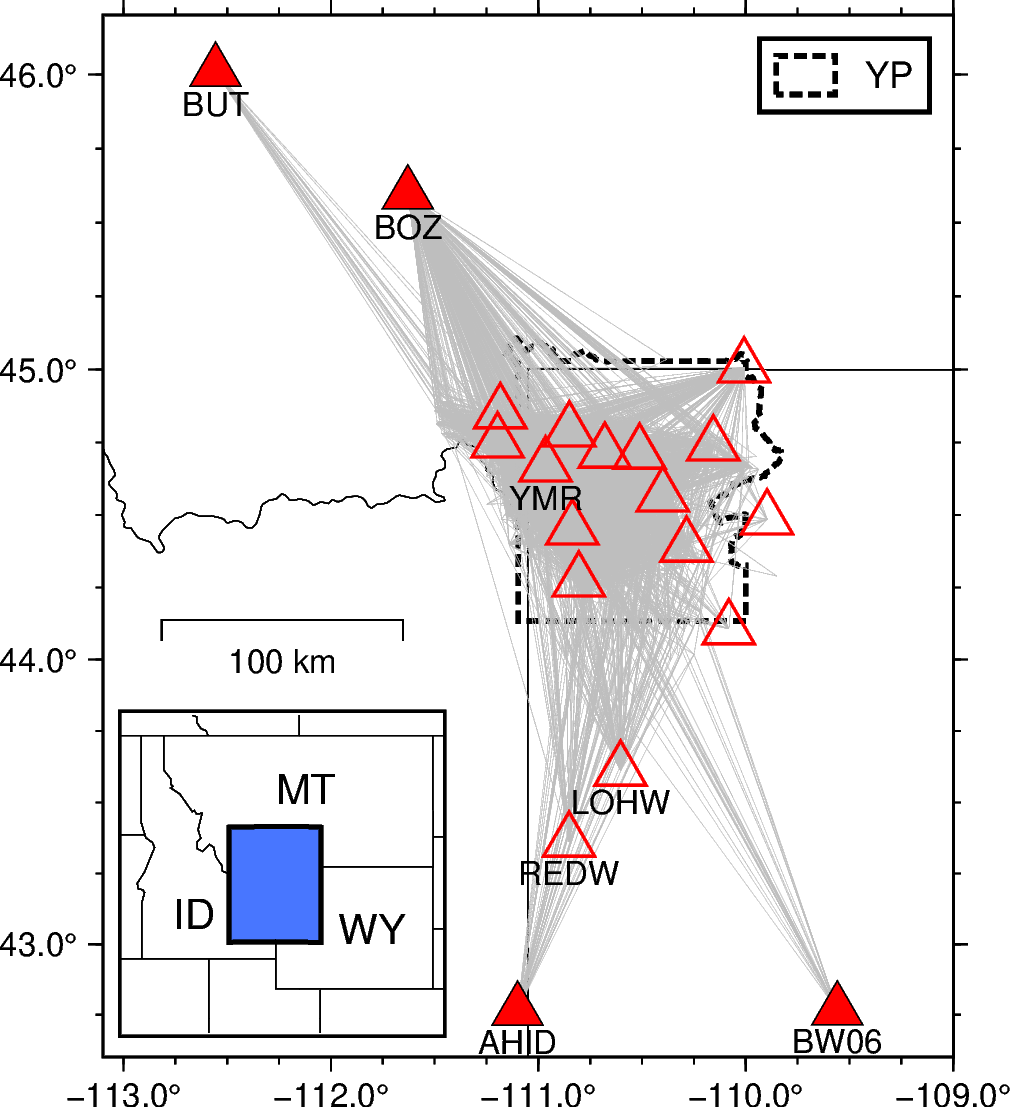

In [25]:
# automatically determine map boundaries from min/max lat/lons 
# of the stations in sta_locs
# ------------------------------------------------------------
ffac = 1.005 # this is a scaling factor to create a region buffer 
ffac = np.array([ffac, 1/ffac]) # lon min should increase bc negative vals
mn = sta_locs[["SLon", "SLat"]].min().values # min lon/lat
mx = sta_locs[["SLon", "SLat"]].max().values # max lon/lat

# interweave the arrays and apply scaling buffer
# ----------------------------------------------
YPAMPREG = np.empty((mn.size + mx.size,), dtype = mn.dtype)
YPAMPREG[0::2] = mn * ffac
YPAMPREG[1::2] = mx * ffac[::-1]

# this is the YS national park boundary for reference
# ---------------------------------------------------
YPLAT, YPLON = ys_bound.copy().T
YPLON *= -1

# useful PyGMT global variables
# -----------------------------
lab_font1 = "8p,Helvetica,black,"
fac = 0.9
fixed_stations = sta_locs["Sta"].isin( # fixed Sj
    ["AHID", "BOZ", "BUT", "BW06"]
)

named_stations = sta_locs["Sta"].isin( # fixed Sj
    ["YMR", "LOHW", "REDW"]
) 


labelled_stations = named_stations | fixed_stations

ssps = np.append(ainv[["EqLon", "EqLat"]].to_numpy(),  ainv[["SLon", "SLat"]].to_numpy(), axis=1)
# make the figure 
# -------------------------------------------------------------
fig = pygmt.Figure()
with pygmt.config(
    MAP_FRAME_TYPE="plain", 
    FORMAT_GEO_MAP="ddd.x", 
    MAP_FRAME_PEN="0.6p,black",
    FONT_ANNOT_PRIMARY="8p,Helvetica,black"
    ):
    # base of the figure
    fig.basemap(
        region = np.round(YPAMPREG, 1), 
        projection = f"M{6*fac}/{8*fac}", 
        frame = ["WSne", "xaf+lx-axis", "yaf+ly-axis"], 
        L = "jCL+c-110.5/39.5N+w100k+o0.5c/-0.8c"
    )
    fig.coast(borders = [1, 2])
    # Yellowstone National Park Boundary
    fig.plot(
        x = YPLON, 
        y = YPLAT,
        pen = "1.25p,black,3_1.5:1.25p",
        close = True,
        label = "YP"
    )
    fig.plot(
        data = ssps,
        style = "=0.5c+s",
        pen = "0.025p,grey"
    )
    fig.plot(
        x = sta_locs[~fixed_stations]["SLon"],
        y = sta_locs[~fixed_stations]["SLat"],
        style = "t0.5c",
        pen = "0.66p,red"
    )
    fig.plot(
        x = sta_locs[fixed_stations]["SLon"],
        y = sta_locs[fixed_stations]["SLat"],
        style = "t0.5c",
        color = "red",
        pen = "0.25p,black"
    )
    fig.text(
        x = sta_locs[labelled_stations]["SLon"],
        y = sta_locs[labelled_stations]["SLat"] - 0.11,
        text = sta_locs[labelled_stations]["Sta"],
        font = lab_font1,
        justify = "CM"
    )
    
    
    with fig.inset(position="n0.02/0.02+w2.75c", box="+p0.75,black"):
        fig.coast(
            region = YPCATREG + np.array([-6, 6, -4.25, 4.25]),
            projection = f"M6/10/?",
            borders = [1, 2]
        )
        fig.plot(
            x = [YPAMPREG[0], YPAMPREG[0], YPAMPREG[1], YPAMPREG[1]],
            y = [YPAMPREG[2], YPAMPREG[3], YPAMPREG[3], YPAMPREG[2]],
            close = True,
            pen = "1.1p,black",
            color = "royalblue1"
        )
        fig.text(
            x = -106.75, 
            y = 43,
            text = "WY",
            font = lab_font
        )
        fig.text(
            x = -114.7, 
            y = 43.5, 
            text = "ID", 
            font = lab_font
        )
        fig.text(
            x = -109.7, 
            y = 47.4, 
            text = "MT", 
            font = lab_font
        )
fig.legend()
fig.savefig("../figures/YP-SSPS-MAP.pdf")
fig.show()